# Toy Examples

synthetic data experiments to test the spherical projection GP approach


In [1]:
import sys
sys.path.append('..')

import numpy as np
import torch
import matplotlib.pyplot as plt
from src.experiments import run_exact_proj_svgp, run_multiple_seeds, run_d_m_sweep_with_frontier, run_sweep_d_multiple_seeds
from src.kernels import (
    SM_kernel,
    stable_matern_kernel,
    stable_rbf_kernel,
    long_periodic_plus_short_rbf
)
from src.data_generation import (
    generate_oscillatory_data,
    generate_piecewise_data,
    generate_piecewise_linear_data
)
from src.config import TrainCfg, SVGPcfg

from src.utils.plotting import plot_reliability_projected_gp



## Modulated Oscillatory Signal

train: 700, test: 300


/Users/arkin/anaconda3/lib/python3.11/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:646.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


             spherical      exact        SVGP
RMSE_test     0.124107   0.098173    0.141877
R2_test       0.999853   0.999908    0.999807
NLPD_test     0.060403  -0.904363   -0.009869
COV95_test  100.000000  94.000000  100.000000
PIW95_test    1.593103   0.382648    1.462695
time_sec      0.419913   5.294003    4.162595


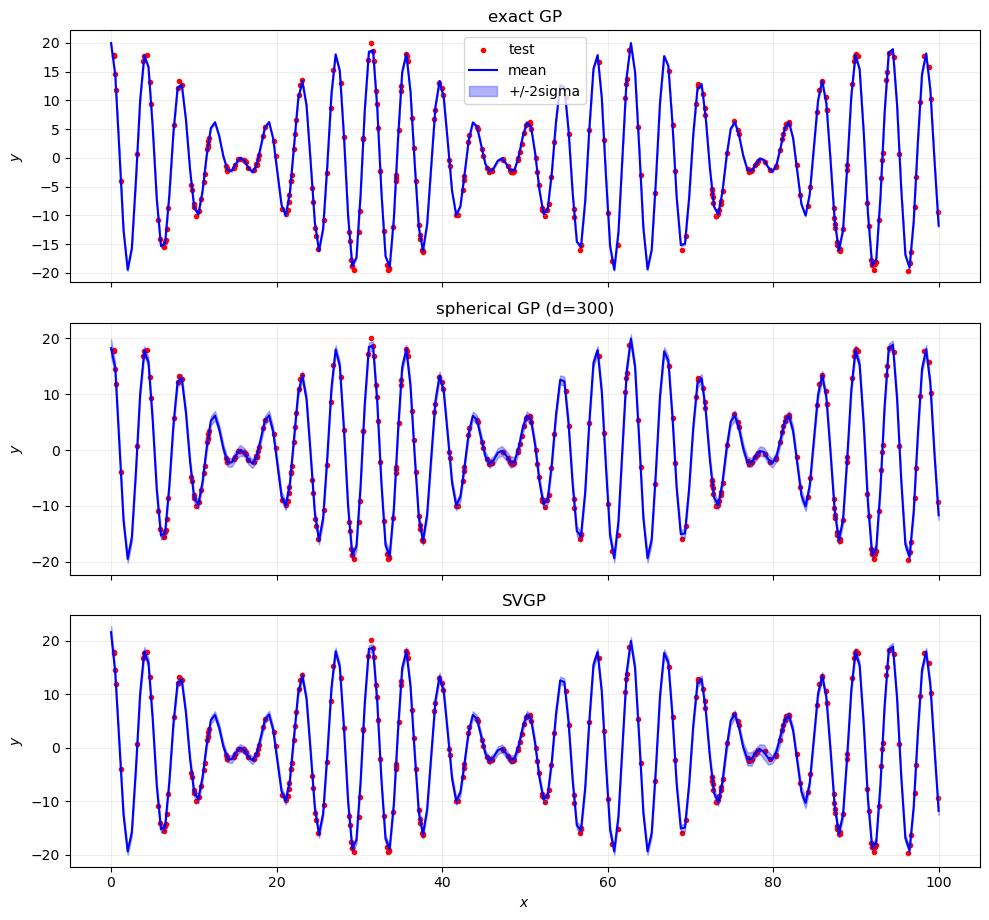

In [2]:
# generate toy data with periodic structure
x_train, y_train, x_test, y_test, x_plot = generate_oscillatory_data(N=1000)
print(f"train: {len(x_train)}, test: {len(x_test)}")

kernel_exact = kernel_proj = kernel_svgp = None#long_periodic_plus_short_rbf(init_period=2.0, init_rbf_lengthscale=1.5)
d_proj = 300

res_exact, res_proj, res_svgp = run_exact_proj_svgp(x_train, y_train, x_test, y_test, d_proj=d_proj, num_mixtures=1,
    cfg=TrainCfg(verbose=False, seed=11, resample_every=10), kernel_exact=kernel_exact, kernel_proj=kernel_proj, kernel_svgp=kernel_svgp,
    x_plot=x_plot, add_svgp=True, init_hyps_data=False, keep_exact=True,
    svgp_cfg=SVGPcfg(m_inducing=128,
        verbose=False,
        steps=500,
        lr_hyp=1e-2,
        lr_ngd=0.05,
        patience=25),
    use_multiscale=False, d_list=[50, 100, 150], flag=False,
    savepath='../results/toy_1d_single_mixture.png')


In [7]:
# aggregate over multiple runs
x_train, y_train, x_test, y_test, x_plot = generate_oscillatory_data(N=1000)
print(f"train: {len(x_train)}, test: {len(x_test)}")

kernel_exact = kernel_proj = kernel_svgp = None #stable_matern_kernel(init_lengthscale=1.0, nu=2.5)
d_proj = 300

results = run_multiple_seeds(x_train, y_train, x_test, y_test, k=10, d_proj=d_proj, num_mixtures=1,
    kernel_exact=kernel_exact, kernel_proj=kernel_proj, kernel_svgp=kernel_svgp,
    cfg=TrainCfg(verbose=False), add_svgp=True, init_hyps_data=False, keep_exact=True, 
    svgp_cfg=SVGPcfg(m_inducing=128, verbose=False,
    steps=300,
    lr_hyp=1e-2,
    lr_ngd=0.05,
    patience=25))


train: 700, test: 300


Running 10 seeds: 100%|██████████| 10/10 [01:17<00:00,  7.71s/it]


=== Summary of 10 runs ===
Base seed: 0
Projection dimension: 300
Number of mixtures: 1
Multi-scale: False
Exact GP included: True
SVGP included: True

=== Metrics Summary ===
spherical_RMSE: 0.1547 ± 0.0419
spherical_NLPD: 0.1694 ± 0.0976
spherical_COV95: 100.0000 ± 0.0000
spherical_time: 0.8517 ± 0.4132
exact_RMSE: 0.0982 ± 0.0000
exact_NLPD: -0.9046 ± 0.0000
exact_COV95: 94.0000 ± 0.0000
exact_time: 4.4506 ± 0.3223
SVGP_RMSE: 0.1887 ± 0.0066
SVGP_NLPD: 0.0394 ± 0.0077
SVGP_COV95: 99.5333 ± 0.2331
SVGP_time: 2.3840 ± 0.1236


### Frontier plot

train: 700, test: 300
Running 5 combined experiments (d_values: [50, 100, 200, 400, 800], m_values: [50, 100, 200, 400, 800])


Combined experiments: 100%|██████████| 5/5 [00:32<00:00,  6.46s/it]


=== Projection Results ===
     d      rmse      time
0   50  0.172514  0.172819
1  100  0.142188  0.299477
2  200  0.116328  0.558172
3  400  0.112383  0.631758
4  800  0.116654  0.738361

=== SVGP Results ===
     m      rmse       time
0   50  0.181840   1.994378
1  100  0.195956   2.253036
2  200  0.224297   3.109877
3  400  0.206181   5.991049
4  800  0.339431  16.457770


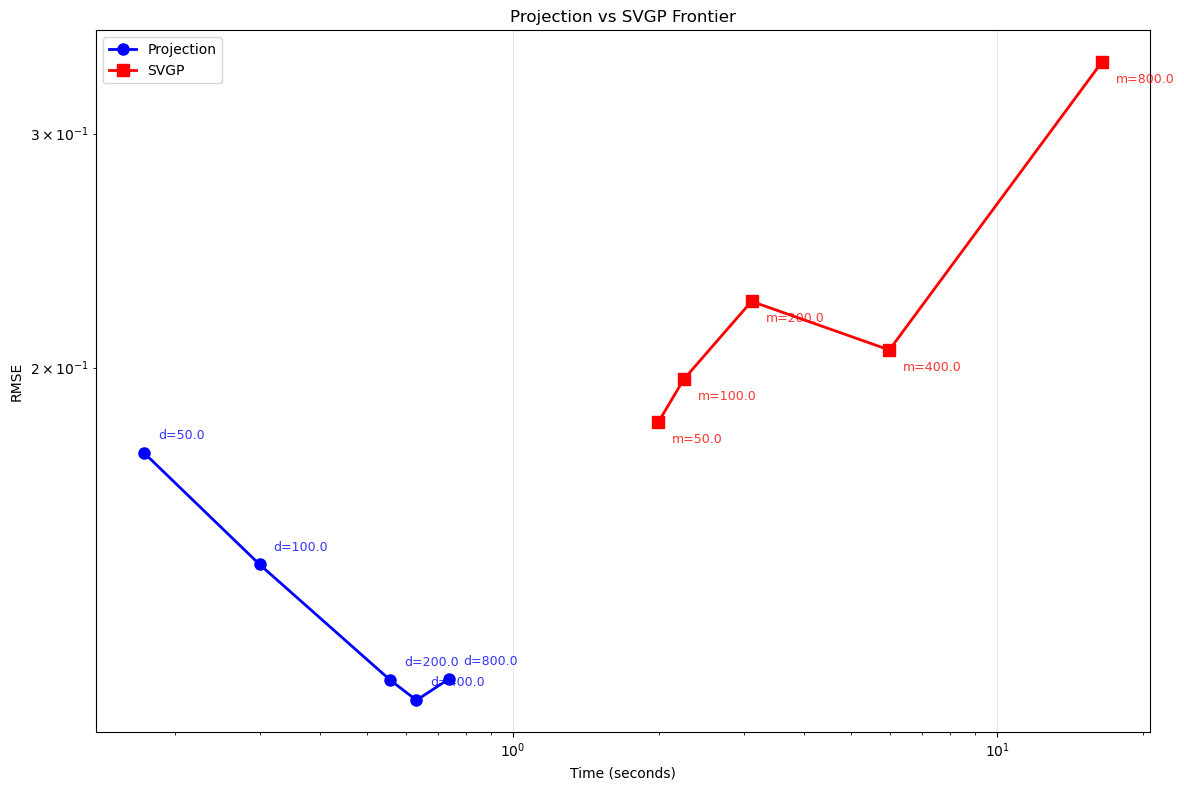

In [ ]:
# frontier plot
x_train, y_train, x_test, y_test, x_plot = generate_oscillatory_data(N=1000)
print(f"train: {len(x_train)}, test: {len(x_test)}")

kernel_exact = kernel_proj = kernel_svgp = stable_rbf_kernel(2)
results = run_d_m_sweep_with_frontier(x_train, y_train, x_test, y_test, num_mixtures=1,
                    kernel_exact=kernel_exact, kernel_proj=kernel_proj, kernel_svgp=kernel_svgp,
                    cfg=TrainCfg(verbose=False),
                    svgp_cfg=SVGPcfg(verbose=False, 
                            batch_size=512,
                            steps=200,
                            lr_hyp=1e-2,
                            lr_ngd=0.05,
                            patience=25))


### Reliabitilty plot

Running reliability analysis with 5 seeds

running spherical GP training | iters=500 lr=0.02 d=300 jitter=0.0001
[proj ] iter=0000 loss=13.228540 Delta=inf ||grad||=3.01e+00
noise=0.1 |raw_noise|grad=0.21151214838027954
[proj ] iter=0100 loss=9.677018 Delta=1.51e-02 ||grad||=1.14e+00
noise=0.118 |raw_noise|grad=0.11279663443565369
[proj ] iter=0200 loss=8.617224 Delta=9.07e-03 ||grad||=8.11e-01
noise=0.137 |raw_noise|grad=0.09122847020626068
[proj] early stop @ 266
[proj ] done | time=1.68s best_loss=7.974292
           GPyTorch (spherical)
weight                 9.303588
scale                  0.196010
mean                   0.283530
noise_var              0.149237
             spherical
RMSE_test     0.130404
R2_test       0.999837
NLPD_test     0.175281
COV95_test  100.000000
PIW95_test    1.804362
time_sec      1.683278
no plotting

running spherical GP training | iters=500 lr=0.02 d=300 jitter=0.0001
[proj ] iter=0000 loss=12.743649 Delta=inf ||grad||=2.67e+00
noise=0.1 |raw_noise

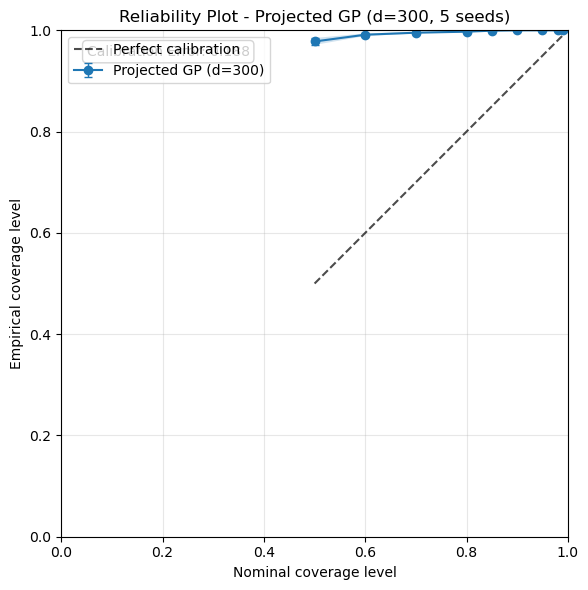

Calibration error: 0.1879


In [2]:
x_train, y_train, x_test, y_test, x_plot = generate_oscillatory_data(N=1000)

results = plot_reliability_projected_gp(
    x_train, y_train, x_test, y_test,
    d_proj=300, n_seeds=5
)

print(f"Calibration error: {results['calibration_error']:.4f}")

## Piecewise Function

train: 700, test: 300
             spherical      exact       SVGP
RMSE_test     0.107747   0.102974   0.106196
R2_test       0.990131   0.990962   0.990397
NLPD_test    -0.120225  -0.852709  -0.815636
COV95_test  100.000000  96.000000  95.000000
PIW95_test    1.317245   0.426160   0.447773
time_sec      6.488898  92.779411  30.883431


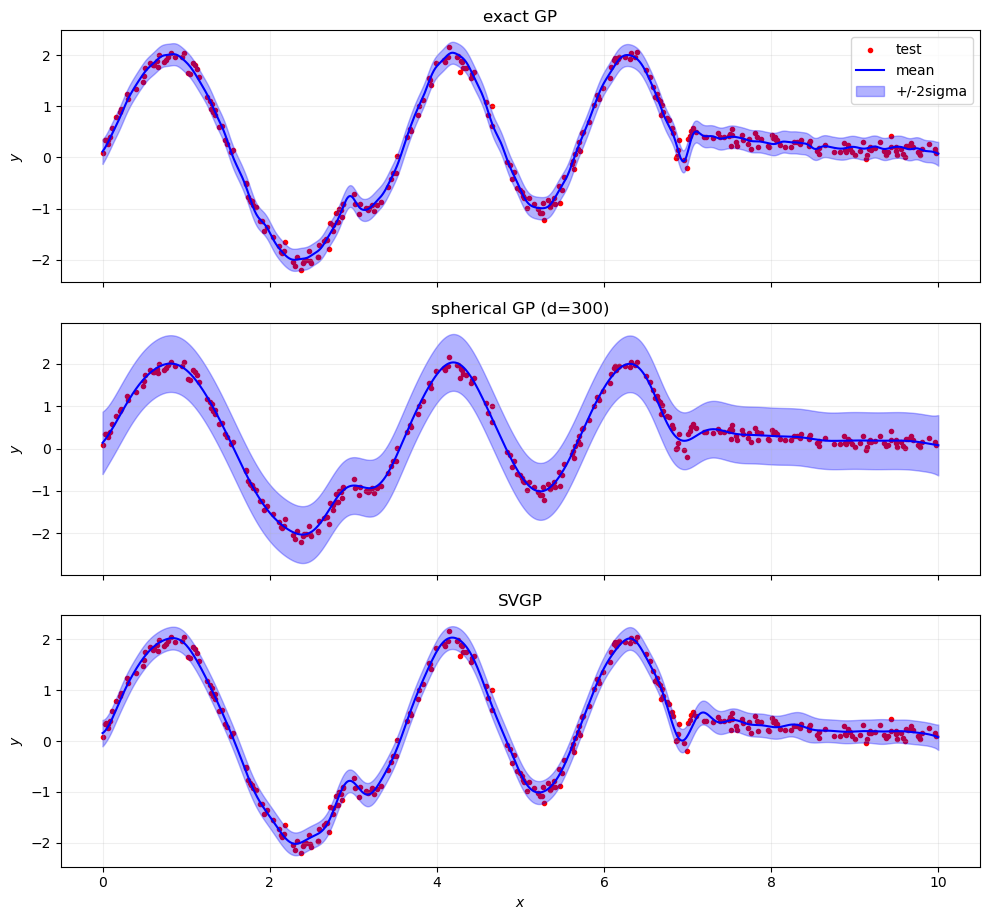

In [6]:
# generate toy data with periodic structure
x_train, y_train, x_test, y_test, x_plot = generate_piecewise_data(N=1000)
print(f"train: {len(x_train)}, test: {len(x_test)}")

kernel_exact = kernel_proj = kernel_svgp = None#stable_rbf_kernel(1.0)
d_proj = 300

res_exact, res_proj, res_svgp = run_exact_proj_svgp(x_train, y_train, x_test, y_test, d_proj=d_proj, num_mixtures=2,
    cfg=TrainCfg(verbose=False, seed=11, resample_every=10), kernel_exact=kernel_exact, kernel_proj=kernel_proj, kernel_svgp=kernel_svgp,
    x_plot=x_plot, add_svgp=True, init_hyps_data=False, keep_exact=True,
    svgp_cfg=SVGPcfg(m_inducing=128,
        verbose=False,
        steps=500,
        lr_hyp=1e-2,
        lr_ngd=0.05,
        patience=25),
    use_multiscale=False, d_list=[50, 100, 150], flag=False,
    savepath='../results/toy_1d_single_mixture.png')


In [8]:
# aggregate over multiple runs
x_train, y_train, x_test, y_test, x_plot = generate_piecewise_data(N=1000)
print(f"train: {len(x_train)}, test: {len(x_test)}")

kernel_exact = kernel_proj = kernel_svgp = None#stable_matern_kernel(init_lengthscale=1.0, nu=2.5)
d_proj = 300

results = run_multiple_seeds(x_train, y_train, x_test, y_test, k=10, d_proj=d_proj, num_mixtures=2,
    kernel_exact=kernel_exact, kernel_proj=kernel_proj, kernel_svgp=kernel_svgp,
    cfg=TrainCfg(verbose=False), add_svgp=True, init_hyps_data=False, keep_exact=True, 
    svgp_cfg=SVGPcfg(m_inducing=128, verbose=False,
    steps=300,
    lr_hyp=1e-2,
    lr_ngd=0.05,
    patience=25))


train: 700, test: 300


Running 10 seeds: 100%|██████████| 10/10 [01:31<00:00,  9.10s/it]


=== Summary of 10 runs ===
Base seed: 0
Projection dimension: 300
Number of mixtures: 2
Multi-scale: False
Exact GP included: True
SVGP included: True

=== Metrics Summary ===
spherical_RMSE: 0.1368 ± 0.0393
spherical_NLPD: -0.1033 ± 0.0648
spherical_COV95: 99.7667 ± 0.6295
spherical_time: 0.8321 ± 0.3000
exact_RMSE: 0.1030 ± 0.0000
exact_NLPD: -0.8527 ± 0.0000
exact_COV95: 96.0000 ± 0.0000
exact_time: 5.5245 ± 0.8607
SVGP_RMSE: 0.1063 ± 0.0004
SVGP_NLPD: -0.8166 ± 0.0027
SVGP_COV95: 95.0333 ± 0.1054
SVGP_time: 2.7186 ± 0.4662


In [24]:
(np.arccos(0.0) + 6*np.pi)/3

6.806784082777885

## Multi-Scale vs Single-Scale Comparison

train: 700, test: 300

Testing multi-scale projections with d_list = [50, 100, 150] (total d = 300)

running exact GP training | iters=500 lr=0.02 lbfgs=False jitter=0.0001
[exact] iter=0000 loss=4.188419 Delta=inf ||grad||=1.59e+01
noise=0.0963 |raw_noise|grad=0.3389677107334137


/Users/arkin/anaconda3/lib/python3.11/site-packages/torch/_compile.py:32: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return disable_fn(*args, **kwargs)


[exact] iter=0100 loss=0.789633 Delta=3.69e-03 ||grad||=6.89e-01
noise=0.00899 |raw_noise|grad=0.0024546210188418627
[exact] iter=0200 loss=0.103670 Delta=6.00e-03 ||grad||=7.55e-01
noise=0.00898 |raw_noise|grad=0.00039586913771927357
[exact] iter=0300 loss=-0.328374 Delta=3.04e-03 ||grad||=4.87e-01
noise=0.00895 |raw_noise|grad=0.0010084694949910045
[exact] iter=0400 loss=-0.534667 Delta=1.08e-03 ||grad||=2.73e-01
noise=0.00899 |raw_noise|grad=0.00061558629386127
[exact] done | time=5.89s best_loss=-0.622521
Running multi-scale projection with d_list = [50, 100, 150] (total d = 300)

running spherical GP training | iters=500 lr=0.02 d=300 jitter=0.0001
[proj ] iter=0000 loss=12.276553 Delta=inf ||grad||=2.57e+00
noise=0.1 |raw_noise|grad=0.18944688141345978
[proj] early stop @ 66
[proj ] done | time=0.42s best_loss=11.228062
           GPyTorch (exact)  GPyTorch (multiscale)
weight             8.594614               6.625411
scale              0.018051               0.221075
mean     

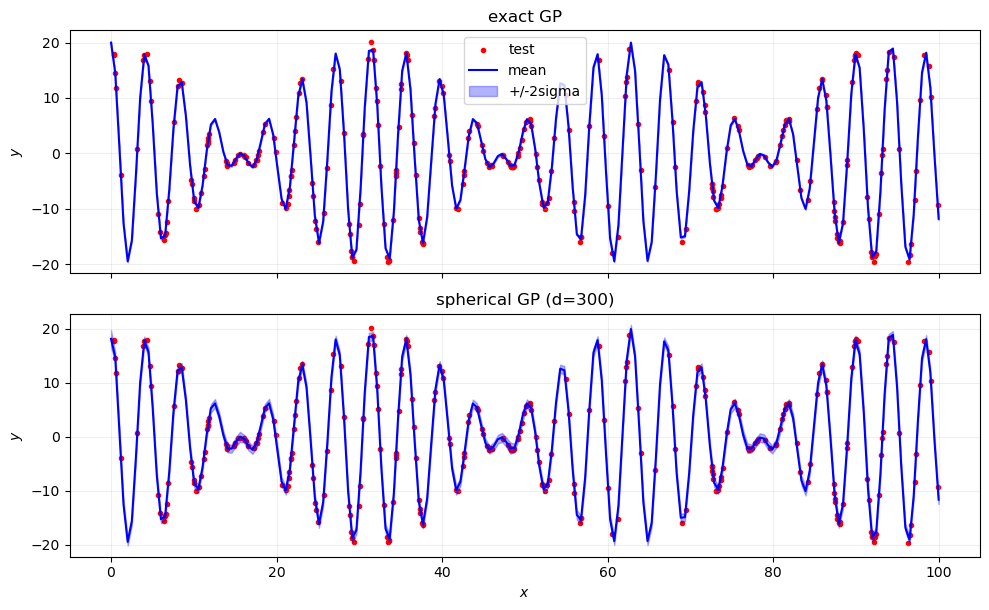

In [ ]:
# Use the same toy data
x_train, y_train, x_test, y_test, x_plot = generate_oscillatory_data(N=1000)
print(f"train: {len(x_train)}, test: {len(x_test)}")

# Test multi-scale projections
d_list = [50, 100, 150]  # fine, medium, coarse scales
print(f"\nTesting multi-scale projections with d_list = {d_list} (total d = {sum(d_list)})")

res_exact, res_proj, res_svgp = run_exact_proj_svgp(x_train, y_train, x_test, y_test, d_proj=d_proj, num_mixtures=1,
                    x_plot=x_plot, add_svgp=False, init_hyps_data=False,
                    use_multiscale=True, d_list=d_list, weighted_multiscale=False, efficient_multiscale=True,
                    savepath='../results/toy_1d_multiscale.png')




## 2D Franke Function


In [5]:
from sklearn.model_selection import train_test_split


def generate_franke_data(N=1000, noise_std=0.1, domain=[0, 1]):
    """Generate data from the Franke function."""    
    def franke_function(x, y):
        """Compute the Franke function value at (x, y)"""
        term1 = 0.75 * np.exp(-((9*x-2)**2 + (9*y-2)**2)/4)
        term2 = 0.75 * np.exp(-((9*x+1)**2)/49 - (9*y+1)/10)
        term3 = 0.5 * np.exp(-((9*x-7)**2 + (9*y-3)**2)/4)
        term4 = -0.2 * np.exp(-((9*x-4)**2 + (9*y-7)**2))
        return term1 + term2 + term3 + term4
    
    # Generate random points in the domain
    x_min, x_max = domain
    rng = np.random.default_rng(0)
    x_coords = rng.uniform(x_min, x_max, N)
    y_coords = rng.uniform(x_min, x_max, N)
    
    # Compute Franke function values
    z_clean = np.array([franke_function(x, y) for x, y in zip(x_coords, y_coords)])
    
    # Add noise - use normal() instead of randn()
    z_noisy = z_clean + noise_std * rng.normal(0, 1, N)
    
    # Combine coordinates
    X = np.column_stack([x_coords, y_coords])
    
    # Split into train/test
    n_train = int(0.7 * N)
    X_tr, X_te, z_tr, z_te = train_test_split(X, z_noisy, test_size=0.3, random_state=0)
    
    # Convert to torch tensors
    x_train = torch.tensor(X_tr, dtype=torch.float32)
    y_train = torch.tensor(z_tr, dtype=torch.float32)
    x_test = torch.tensor(X_te, dtype=torch.float32)
    y_test = torch.tensor(z_te, dtype=torch.float32)
    
    # Create grid for plotting
    grid_size = 100
    x_grid_1d = np.linspace(x_min, x_max, grid_size)
    y_grid_1d = np.linspace(x_min, x_max, grid_size)
    X_grid, Y_grid = np.meshgrid(x_grid_1d, y_grid_1d)
    
    # Flatten grid for evaluation
    x_grid = np.column_stack([X_grid.ravel(), Y_grid.ravel()])
    x_grid = torch.tensor(x_grid, dtype=torch.float32)
    
    grid_shape = (grid_size, grid_size)
    extent = (x_min, x_max, x_min, x_max)
    
    return x_train, y_train, x_test, y_test, x_grid, grid_shape, extent



=== 2D Franke Function ===
Train: 700, Test: 300
Grid shape: (100, 100)

running exact GP training | iters=800 lr=0.05 lbfgs=False jitter=0.0001
[exact] iter=0000 loss=-0.159159 Delta=inf ||grad||=4.72e-01
noise=0.0954 |raw_noise|grad=0.44573691487312317
[exact] iter=0100 loss=-1.482988 Delta=6.94e-05 ||grad||=1.33e-02
noise=0.00227 |raw_noise|grad=0.012767511419951916
[exact] converged @ 145
[exact] done | time=4.14s best_loss=-1.483285

running spherical GP training | iters=800 lr=0.05 d=200 jitter=0.0001
[proj ] iter=0000 loss=0.610407 Delta=inf ||grad||=1.45e-01
noise=0.0995 |raw_noise|grad=0.04610191285610199
[proj ] iter=0100 loss=0.511444 Delta=2.60e-04 ||grad||=5.73e-02
noise=0.0639 |raw_noise|grad=0.05082370713353157
[proj] early stop @ 166
[proj ] done | time=3.37s best_loss=0.510989
                                       GPyTorch (spherical)  \
weight                            [0.39378104, 0.031324476]   
scale      [0.072135575, 0.3024589, 0.09754708, 0.11342917]   
mean  

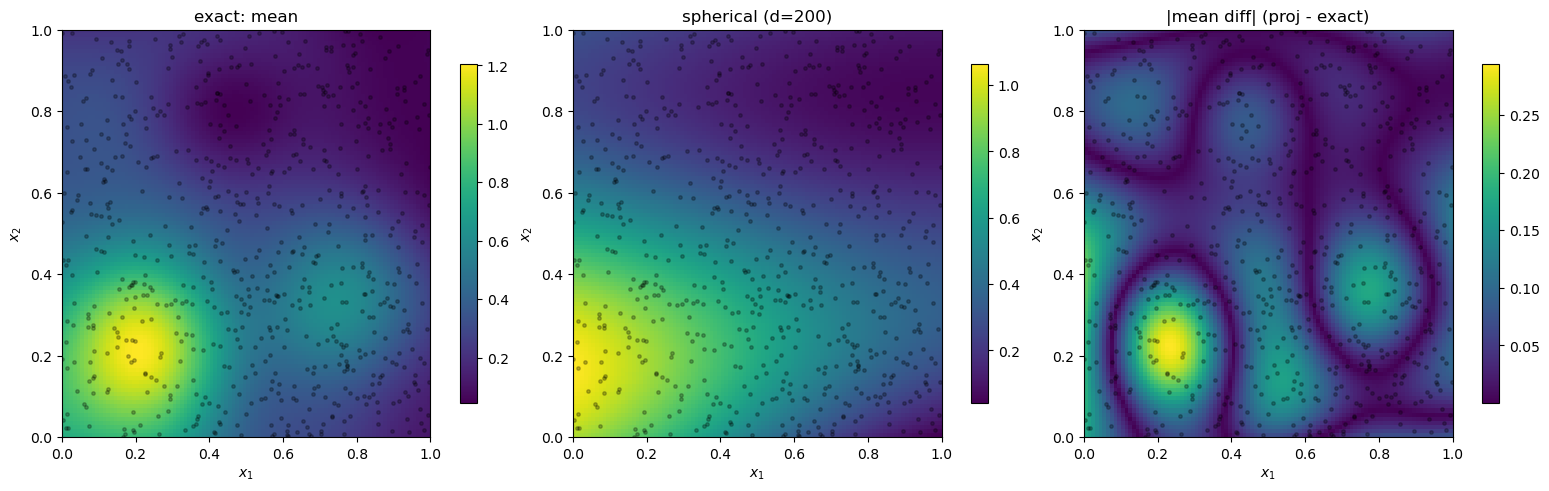

In [ ]:
x_train, y_train, x_test, y_test, x_grid, grid_shape, extent = generate_franke_data(
    N=1000, noise_std=0.05, domain=[0, 1]
)

print(f"Train: {len(x_train)}, Test: {len(x_test)}")
print(f"Grid shape: {grid_shape}")

torch.manual_seed(0)
np.random.seed(0)

_, _, _ = run_exact_proj_svgp(
    x_train, y_train, x_test, y_test,
    x_grid=x_grid, grid_shape=grid_shape, extent=extent,
    d_proj=200,
    num_mixtures=2,
    cfg=TrainCfg(verbose=True, max_iter=800, lr=0.05),
    add_svgp=False,
    savepath='../results/franke_2d.png'
)